### A.1.第一步拆分文件使得 BD[i] 即为访问 股票 i 的数据，并计算ER 一个含有12个数据的列表，每个数据代表每一个股票的期望收益率

In [ ]:
# 表格中的基本内容 "Actif","Dates","Ouverture","Max","Min","Fermeture","Volume"
import numpy as np
import numpy.linalg as cm
import pandas as pd
import glob

# 获取目录下所有的 .xlsm 文件
file_list = glob.glob('action/*.xlsm')

# 读取所有文件并存储为一个列表
BD = [pd.read_excel(file, engine='openpyxl') for file in file_list]

#ER每个股票的期望收益率
ER = np.ones((12,1)) #np.ones((12,1)) 生成一个12行1列的全1矩阵
for j in range(12):
    bd = BD[j] 
    St= [(bd.iloc[i, 3]+bd.iloc[i, 4])/2 for i in range(255)] #St 是每个股票的收盘价
    Rt= [(St[i+1]/St[i]) -1 for i in range(254)] #Rt 是每个股票的收益率
    ER[j] = np.mean(Rt) #ER[j] 是每个股票的期望收益率


### A.2. 计算在 efficient frontier 函数所需要的参数 a，b，norm，公式如下：m_sigma=b/a+sqrt(sigma^2-1/a)*norm , m_sigma即为该sigma下的最大的期望收益率

In [30]:
#SIGMA协方差矩阵
SIGMA = np.ones((12,12))

for i in range(12):
    for j in range(12):
        bdi = BD[i]
        Sti = [(bdi.iloc[k, 3]+bdi.iloc[k, 4])/2 for k in range(255)]
        Rti = [(Sti[k+1]/Sti[k]) -1 for k in range(254)] #Rti 是股票i的收益率列表
        RtiC=Rti-np.mean(Rti) #RtiC是Rti的中心化序列 
        #Rti=np.array(Rti)
        #RtiC=Rti-ER[i]
        
        bdj = BD[j]
        Stj = [(bdj.iloc[k, 3]+bdj.iloc[k, 4])/2 for k in range(255)]
        Rtj = [Stj[k+1]/Stj[k] -1 for k in range(254)] #Rtj 是股票j的收益率列表
        RtjC=Rtj-np.mean(Rtj) #RtjC是Rtj的中心化序列
        #Rtj=np.array(Rtj)
        #RtjC=Rtj-ER[j]

        # listeV是协方差矩阵的第i行第j列的元素，其值为两个股票的协方差，有254个值，取平均值
        #listeV = [RtiC[k]*RtjC[k] for k in range(254)] #cov(X,Y) = E[(X - E[X])(Y - E[Y])]
        listeV=[RtiC*RtjC ]
        SIGMA[i,j] = np.mean(listeV)


#Vérification 
print('determinant: ',np.linalg.det(SIGMA))
SIGMA_inv = cm.inv(SIGMA)
print('SIGMA_inv: ',SIGMA_inv)
vect1 = np.ones((12,1)) #生成一个12行1列的全1矩阵
vect1T = np.transpose(vect1)
a = np.dot(vect1T,np.dot(SIGMA_inv,vect1))
print('a: ',a)
a=a[0][0]
print('a: ',a)
b=np.dot(vect1T,np.dot(SIGMA_inv,ER))
print('b: ',b)
b=b[0][0]
print('b: ',b)



vect = ER-(b/a)*vect1
vectT = np.transpose(vect)
norm2 = np.dot(vectT,np.dot(SIGMA_inv,vect))
norm2 = norm2[0][0]
norm = np.sqrt(norm2)
print('norm: ',norm2)

        

determinant:  1.7470455596539675e-48
SIGMA_inv:  [[ 2.94689411e+03 -6.96709486e+02  8.99074220e+00 -5.24411228e+02
   1.68941456e+02  7.37476165e+01  8.13750198e+01 -1.48037647e+01
  -1.23021941e+03 -2.23710796e+02  1.55850458e+02 -6.48114206e+02]
 [-6.96709486e+02  1.60761396e+04 -1.63114727e+03 -2.64677697e+03
  -3.45747860e+02  6.45772107e+02 -1.82550267e+03 -1.68036989e+03
  -2.90104446e+03 -6.92694723e+03  6.26968348e+02 -4.76335646e+02]
 [ 8.99074220e+00 -1.63114727e+03  1.45912406e+04 -4.92197815e+02
  -2.20684751e+03  8.94453677e+01 -5.08879934e+02  5.80951753e+02
  -1.62280035e+03 -1.76895593e+03 -2.94910331e+03 -7.48971789e+02]
 [-5.24411228e+02 -2.64677697e+03 -4.92197815e+02  1.56847711e+04
  -2.77228474e+03 -7.30772197e+02 -1.06525966e+03  2.82882961e+02
  -1.96778188e+03  8.74934819e+01 -8.43163082e+02 -9.97592070e+02]
 [ 1.68941456e+02 -3.45747860e+02 -2.20684751e+03 -2.77228474e+03
   9.91947578e+03 -4.18747372e+02 -1.12393864e+03 -2.00502083e+03
   1.31521266e+03 -5.06

### A.3.对应画出 3条相关的曲线

/var/folders/b4/6b5cdwqx3qd94p_4bdv167zm0000gn/T/ipykernel_4028/2461624801.py:4: RuntimeWarning: invalid value encountered in sqrt
  y = b/a + np.sqrt(sigma**2 - 1/a)*norm
/var/folders/b4/6b5cdwqx3qd94p_4bdv167zm0000gn/T/ipykernel_4028/2461624801.py:9: RuntimeWarning: invalid value encountered in sqrt
  y = b/a - np.sqrt(sigma**2 - 1/a)*norm


Text(0.5, 0, 'sigma')

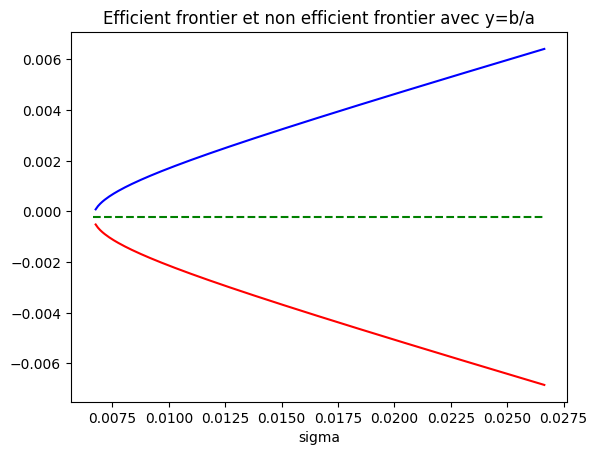

In [31]:
import matplotlib.pyplot as plt
#frontière efficiente
def FE(a,b,sigma,norm):
    y = b/a + np.sqrt(sigma**2 - 1/a)*norm
    return y

#frontière non efficiente
def FNE(a,b,sigma,norm):
    y = b/a - np.sqrt(sigma**2 - 1/a)*norm
    return y

#constante
def cste(a,b):
    y = b/a
    return y

axesigma = np.linspace(1/np.sqrt(a),4/np.sqrt(a),200)
axey1 = [FE(a,b,sigma,norm) for sigma in axesigma]
axey2 = [FNE(a,b,sigma,norm) for sigma in axesigma]
axey3 = [cste(a,b) for sigma in axesigma]
plt.title('Efficient frontier et non efficient frontier avec y=b/a')
plt.plot(axesigma,axey1,label='Efficient frontier',color='blue')
plt.plot(axesigma,axey2,label='Non efficient frontier',color='red')
plt.plot(axesigma,axey3,label='y=b/a',color='green',linestyle='--')
plt.xlabel('sigma')



### A.4.云图的生成 ： 随机生成X（也就是12个股票分别的百分比函数），对应 portefeuil的sigma标准差横轴，以及ER期望的收益率纵轴

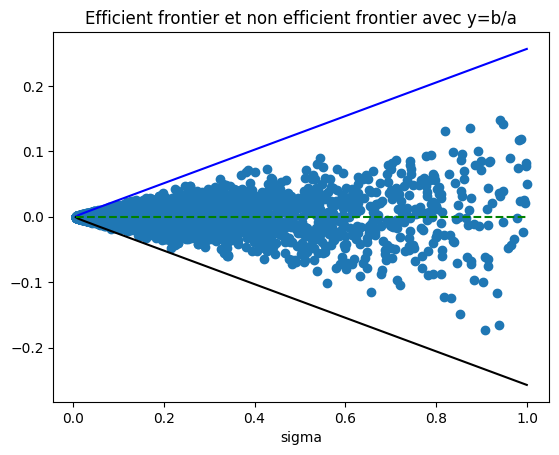

In [32]:
# point de nuage
import numpy.random as npr
NS = 50000
AX1 = []
AX2 = []
for j in range(NS):
    x = npr.randn(12) #生成12个服从标准正态分布的随机数 #randn 标准差为1 均值为0
    s= np.sum(x) #求和
    if s==0:
        x[0]+=1 #如果和为0，将第一个值加1
    else:
        x = x/s #如果和不为0，将x的值除以和
    xT = np.transpose(x) 
    #esp = np.dot(x,ER) #期望收益率
    esp = np.dot(xT,ER)#期望收益率
    var = np.dot(xT,np.dot(SIGMA,x)) #！！！方差
    sig = np.sqrt(var) #标准差
    if sig<=1:
        AX1.append(sig)
        AX2.append(esp)
#画出云图
plt.scatter(AX1,AX2)

axesigma = np.linspace(min(AX1),max(AX1),200)
#axesigma = np.linspace(1/np.sqrt(a),4/np.sqrt(a),200)
axey1 = [FE(a,b,sigma,norm) for sigma in axesigma]
axey2 = [FNE(a,b,sigma,norm) for sigma in axesigma]
axey3 = [cste(a,b) for sigma in axesigma]


plt.title('Efficient frontier et non efficient frontier avec y=b/a')
plt.plot(axesigma,axey1,label='Efficient frontier',color='blue')
plt.plot(axesigma,axey2,label='Non efficient frontier',color='black')
plt.plot(axesigma,axey3,label='y=b/a',color='green',linestyle='--')
plt.xlabel('sigma')

plt.show()



    

### A.5 反复模拟随机生成权重，取最优的权重（删选条件为： sig <= Sigmax）

In [33]:
import numpy as np
import numpy.random as npr

# choix de sigma
Sigmax = 0.02  # 最大风险（标准差）
Espmax = -10 * 10  # 初始期望收益的最小值


# 初始最优投资组合
x_opt = np.array([1 for _ in range(12)]) 

# 随机化搜索最优组合
for _ in range(NS):
    # 随机生成权重
    x = [npr.uniform() for _ in range(12)]  # 均匀分布生成权重 uniform() 生成0-1之间的随机数
    x = np.array(x)  # 转为 numpy 数组
    s = np.sum(x)  # 权重总和

    # 确保权重总和不为 0
    if s == 0:
        x[0] = 1 # 如果权重总和为0，将第一个权重设置为1
    else:
        x = x / s  # 归一化权重

    # 计算方差和标准差
    xT = np.transpose(x)  # 转置权重向量
    var = np.dot(xT, np.dot(SIGMA, x))  # 计算方差
    sig = np.sqrt(var)  # 计算标准差

    # 检查是否满足风险约束
    if sig <= Sigmax:
        # 计算期望收益
        esp = np.dot(xT, ER)
        # 检查是否为当前最大期望收益
        if esp > Espmax:
            Espmax = esp  # 更新最大期望收益
            x_opt = x  # 更新最优组合

# 输出结果
print("最优投资组合 x_opt:")
print(x_opt)
print(f"对应的期望收益: {Espmax}")
print(f"对应的风险（标准差）: {Sigmax}")


最优投资组合 x_opt:
[0.02019499 0.02594646 0.08146239 0.04962503 0.27964854 0.02063618
 0.01179959 0.24123841 0.0567135  0.02052939 0.15115794 0.04104757]
对应的期望收益: [-0.00013442]
对应的风险（标准差）: 0.02


### A.5 反复模拟随机生成权重，取最优的权重（删选条件为：VaR_95（R^x） <= 1/100 :）

In [60]:
import numpy as np
import numpy.random as npr

# !!! 计算收益率矩阵 Rti (12, 254)
Rti = np.zeros((12, 254))  # 12 行（股票），254 列（时间）
for j in range(12):
    bd = BD[j]
    St = [(bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(255)]
    Rti[j, :] = [(St[i + 1] / St[i]) - 1 for i in range(254)]  # 直接赋值到 Rti 矩阵


# choix de VaR_max
VaR_max = 2/ 100  # !!!VaR 约束
Espmax = -np.inf  # 初始最优期望收益
NS = 1000000  # 随机搜索次数


# 初始最优投资组合
x_opt = np.array([1 for _ in range(12)]) 

# 随机化搜索最优组合
for _ in range(NS):
    # 随机生成权重
    x = [npr.uniform() for _ in range(12)]  # 均匀分布生成权重 uniform() 生成0-1之间的随机数
    x = np.array(x)  # 转为 numpy 数组
    s = np.sum(x)  # 权重总和

    # 确保权重总和不为 0
    if s == 0:
        x[0] = 1 # 如果权重总和为0，将第一个权重设置为1
    else:
        x = x / s  # 归一化权重

    # 计算投资组合收益率序列 
    #Rt_x = X'*Rt  X'是权重向量的转置，Rt是收益率序列
    x_T = np.transpose(x)  # 转置权重向量
    Rt_x =np.dot(x_T,Rti) #!!!! ( 每一刻的R^x
    R_x_hist =np.array([Rt_x[i] for i in range(254)]) #!!!!
    
    # 计算 VaR 95%
    VaR_95 = np.quantile(-R_x_hist, 0.95) #!!!!

    # 如果满足 VaR 约束，则尝试最大化期望收益
    if VaR_95 <= VaR_max:
        esp = np.dot(x, ER)  # 计算期望收益
        if esp > Espmax:
            Espmax = esp
            x_opt = x  # 更新最优权重
    
    if VaR_95 <= VaR_max:
        break

# 输出最优投资组合
print("最优投资组合 x_opt:")
print(x_opt)
print(f"对应的期望收益: {Espmax}")
print(f"对应的 VaR_95: {VaR_95}")


最优投资组合 x_opt:
[0.09320788 0.0241251  0.08687758 0.06482443 0.0227063  0.06864805
 0.07836748 0.14818581 0.06660625 0.09211152 0.11053761 0.14380199]
对应的期望收益: [-0.00061629]
对应的 VaR_95: 0.015866519208374175


### B.1 提取出来2019年的数据 
### BD2019[i]就代表 股票i 在2019时的价格列表

In [34]:
# 生成一个只包含2019年数据的BD
BD2019 = []

for df in BD:
    # 将日期列转换为datetime格式
    df.iloc[:, 1] = pd.to_datetime(df.iloc[:, 1], format='%d/%m/%Y') # iloc[:, 1] 选择第二列
    # 过滤出2019年的数据
    df_2019 = df[df.iloc[:, 1].dt.year == 2019]
    BD2019.append(df_2019)

# 验证结果
for i, df in enumerate(BD2019): # enumerate() 函数用于将一个可遍历的数据对象组合为一个索引序列
    print(f"File {i+1} - Number of rows: {len(df)}")
    print(df.head())

File 1 - Number of rows: 245
     FR0000125585 2018-01-02 00:00:00  50.78   51.3  50.72   51.1  238259
254  FR0000125585          2019-01-02  36.00  36.16  34.01  34.55  911549
255  FR0000125585          2019-01-03  34.55  35.75  34.06  35.70  484758
256  FR0000125585          2019-01-04  35.80  36.24  35.37  35.73  295196
257  FR0000125585          2019-01-07  35.81  36.36  35.61  36.10  347869
258  FR0000125585          2019-01-08  35.99  36.81  35.99  35.99  354629
File 2 - Number of rows: 245
     FR0000131104 2018-01-02 00:00:00   62.68    62.7   61.66   62.09  2785984
254  FR0000131104          2019-01-02  38.730  39.105  38.135  39.085  4275030
255  FR0000131104          2019-01-03  38.780  39.565  38.600  38.855  4011198
256  FR0000131104          2019-01-04  39.400  40.830  39.175  40.740  5325079
257  FR0000131104          2019-01-07  41.120  41.120  40.265  40.680  4195675
258  FR0000131104          2019-01-08  40.705  41.350  40.470  40.885  4372775
File 3 - Number of rows:

### 

### B.2 给定初级资金 10**5 次方，采用x_opt为初始百分比，调整每一次的持仓量，计算出C_t对应于t的变化

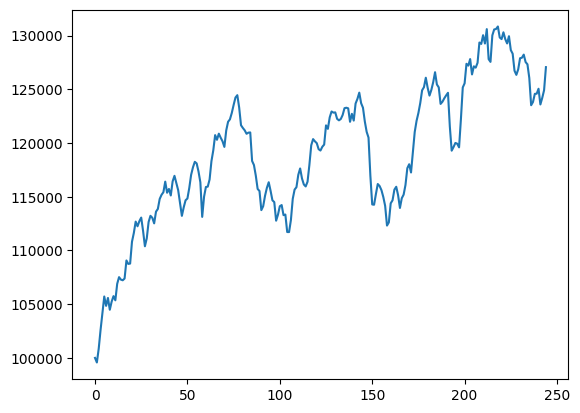

In [35]:
#1.设定给的条件
C = 100000 # 初始资金

Ct=[C]

S = [[] for _ in range(12)] # 2019年每只股票的收盘价

for i in range(12):
    S[i] = [(BD2019[i].iloc[j, 3]+BD2019[i].iloc[j,4])/2 for j in range(len(BD2019[i]))] # S[i] 是第i只股票2019年的的价格列表


S0 = np.array([S[i][0] for i in range(12)]) # S0含有2019年每只股票的第0天的价格
theta=np.array([int(C*x_opt[i]/S0[i]) for i in range(12)]) #theta是初始持仓量，即每个股票的初始购买量，资本总量*百分比/价格
thetaT=np.transpose(theta)
cash = C - np.dot(thetaT,S0) # cash是初始现金
#print('第1天后的股票价格：',np.dot(theta,S0))
#print('第1天还剩下的现金价格:',cash)
#CashList = [cash] #存储每个时刻t对应的现金

#从第二天到&2019年最后一天
for t in range (1,len(BD2019[0])): #len(BD2019[0])是2019年的天数，也是数据的行数
    #Rt = [(S[i][t]/S[i][t-1])-1 for i in range(12)] # 含有每只股票的收益率 (12只股票在t时刻的收益率)

    # 1.计算新的资本
    St=np.array([S[i][t] for i in range(12)]) # St含有2019年每只股票的第t天的价格
    C=cash + np.dot(thetaT,St) # cash 是t-1时刻的现金, thetaT是t-1时刻的持仓量，St是t时刻的股票价格
    #print('第',t+1,'天后的股票价格：',np.dot(theta,St))
    # 2.计算新的持仓量
    theta=np.array([int(C*x_opt[i]/S[i][t]) for i in range(12)])
    thetaT=np.transpose(theta)  
    # 3.计算新的现金
    cash = C - np.dot(thetaT,St)
    #print('第',t+1,'天后的现金价格:',cash)
    Ct.append(C)
    #CashList.append(cash)

#print(CashList)
# 输出结果
plt.plot(Ct)
#plt.plot(CashList)

### B.3整理后的代码

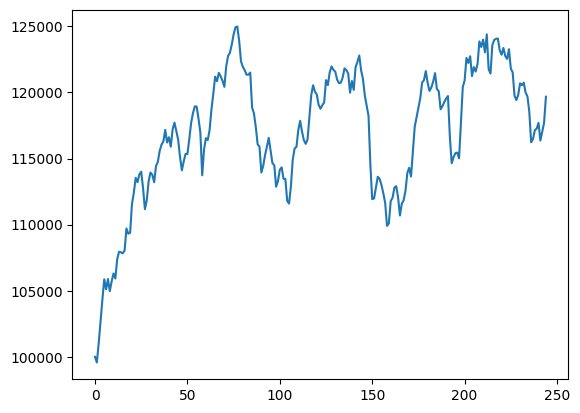

In [37]:
#1.设定给的条件+S[i]第i只股票2019年的的价格列表
C = 100000 #
Ct=[C]

S = [[] for _ in range(12)] # 2019年每只股票的收盘价

for i in range(12):
    S[i] = [(BD2019[i].iloc[j, 3]+BD2019[i].iloc[j,4])/2 for j in range(len(BD2019[i]))] # S[i] 是第i只股票2019年的的价格列表


#2.计算第一天后的cash和股票总价值，S0是2019年每只股票的第0天的价格
S0 = np.array([S[i][0] for i in range(12)]) 
theta=np.array([int(C*x_opt[i]/S0[i]) for i in range(12)]) 
thetaT=np.transpose(theta)
cash = C - np.dot(thetaT,S0) 

#计算从第二天到&2019年最后一天 的股票总价值，St是2019年每只股票的第t天的价格
for t in range (1,len(BD2019[0])): 
    St=np.array([S[i][t] for i in range(12)]) 
    C=cash + np.dot(thetaT,St) 
    theta=np.array([int(C*x_opt[i]/S[i][t]) for i in range(12)])
    thetaT=np.transpose(theta)  
    Ct.append(C)

plt.plot(Ct)
